In [1]:
from IPython.display import HTML, display, Image

import warnings
warnings.filterwarnings('ignore')

# Probeset selection with Spapros

In this tutorial we showcase how to select a gene set with Spapros.    

Based on a scRNA-seq reference dataset Spapros selects genes that can distinguish the cell types in that data set and 
capture transcriptomic varation beyond cell type labels.

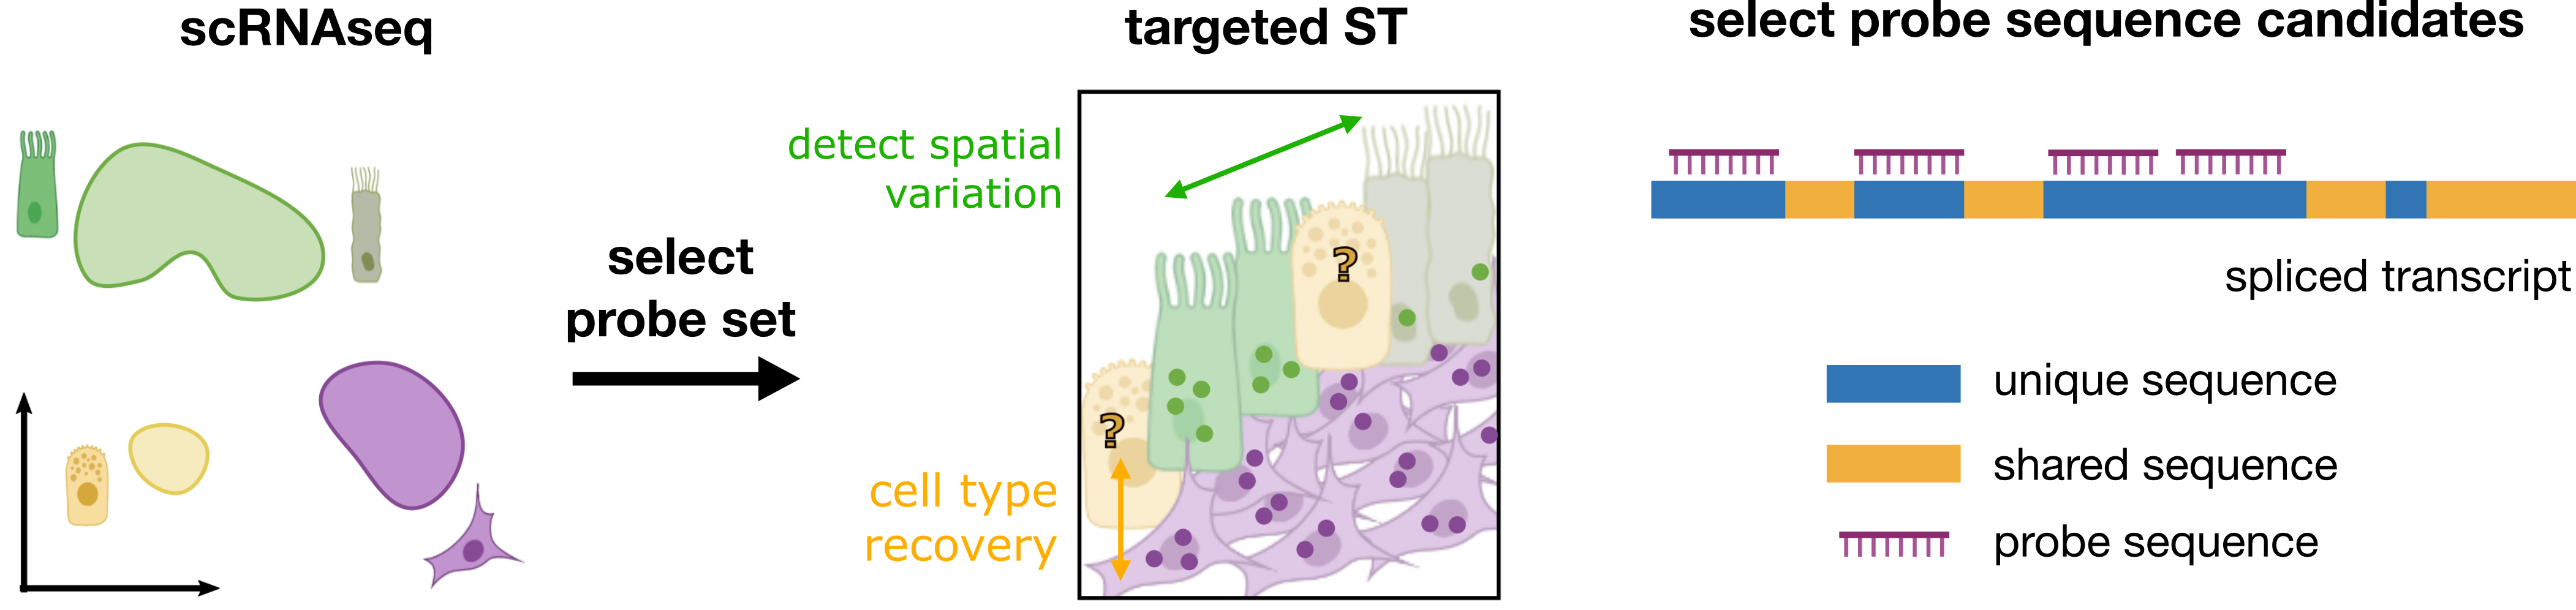

In this tutorial we will use the default selection settings only. Check out the [advanced selection tutorial](./spapros_tutorial_advanced_selection.ipynb) for adjustments for specific use cases and the [end-to-end probe set selection tutorial](./spapros_tutorial_end_to_end_selection.ipynb) which includes the probe design.

## Import packages

In [2]:
import scanpy as sc
import spapros as sp
import os 

In [3]:
sc.settings.verbosity = 0
sc.logging.print_header()
print(f"spapros=={sp.__version__}")

datadir = "../../datasets/Hands_on_5_Spapros"

spapros==0.1.5


## Load and preprocess data

For Spapros selections the count data should be log-normalised. Notably genes should **not** be scaled to mean=0 and std=1. We pre-select a given number of highly variable genes, here 1000. In real world applications we typically go for 8000.   
    
The example data set that we use here has a raw version and a processed version with scaled counts. To get log normalised counts we use the raw version. Cell and gene filters, cell type annotations, and the umap embedding we get from the processed version.

In [4]:
adata = sc.datasets.pbmc3k()
adata_tmp = sc.datasets.pbmc3k_processed()

# Get infos from the processed dataset
adata = adata[adata_tmp.obs_names,adata_tmp.var_names]
adata.obs['celltype'] = adata_tmp.obs['louvain']
adata.obsm['X_umap'] = adata_tmp.obsm['X_umap']
del adata_tmp

# Preprocess counts and get highly variable genes
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,flavor="cell_ranger",n_top_genes=1000)

adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'celltype'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'

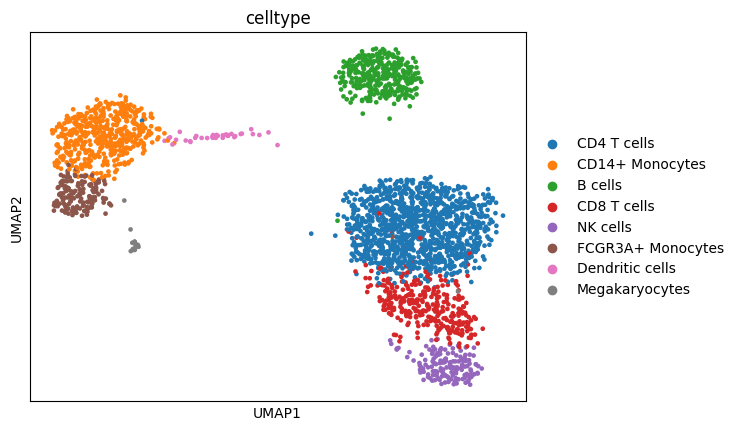

In [5]:
sc.pl.umap(adata,color="celltype")

## Run selection
First we create an instance of the `ProbesetSelector` class. We specify the number of genes `n` (20) and the key in `adata.obs` where we find the cell type annotations (`celltype_key="celltype"`). Note that you can specify a `save_dir` to save results during selection and reload them next time a `ProbesetSelector` with the given `save_dir` is instantiated.

In [6]:
selector = sp.se.ProbesetSelector(adata, n=20, celltype_key="celltype", verbosity=1, save_dir="spapros_selection_basic")

Note: The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3
The genes selected for those cell types potentially don't generalize well. Find the genes for each of those cell types in self.genes_of_primary_trees after running self.select_probeset().
Searching for previous results in spapros_selection_basic


We get a warning that the cell type clusters for dendritic cells and megakaroycytes are quite small and therefore the 
genes that are selected to identify these cell types potentially don't generalize very well. The method won't exclude
these cell types automatically, it could be done manually though by setting the parameter `celltypes` to a subset of
cell types instead of `celltypes="all"`.

`selector.select_probeset()` is the central method for probe set selection. (Takes ~5 min for the given example. Note that the progress bars should be properly displayed with jupyter notebook, however jupyter lab or e.g. vscode can lead to incomplete display)
The tree training step requires ~30GB memory and 16 CPUs, which might not be available so you can instead load the precomputed results. 
We ran:
```python
selector.select_probeset()
```

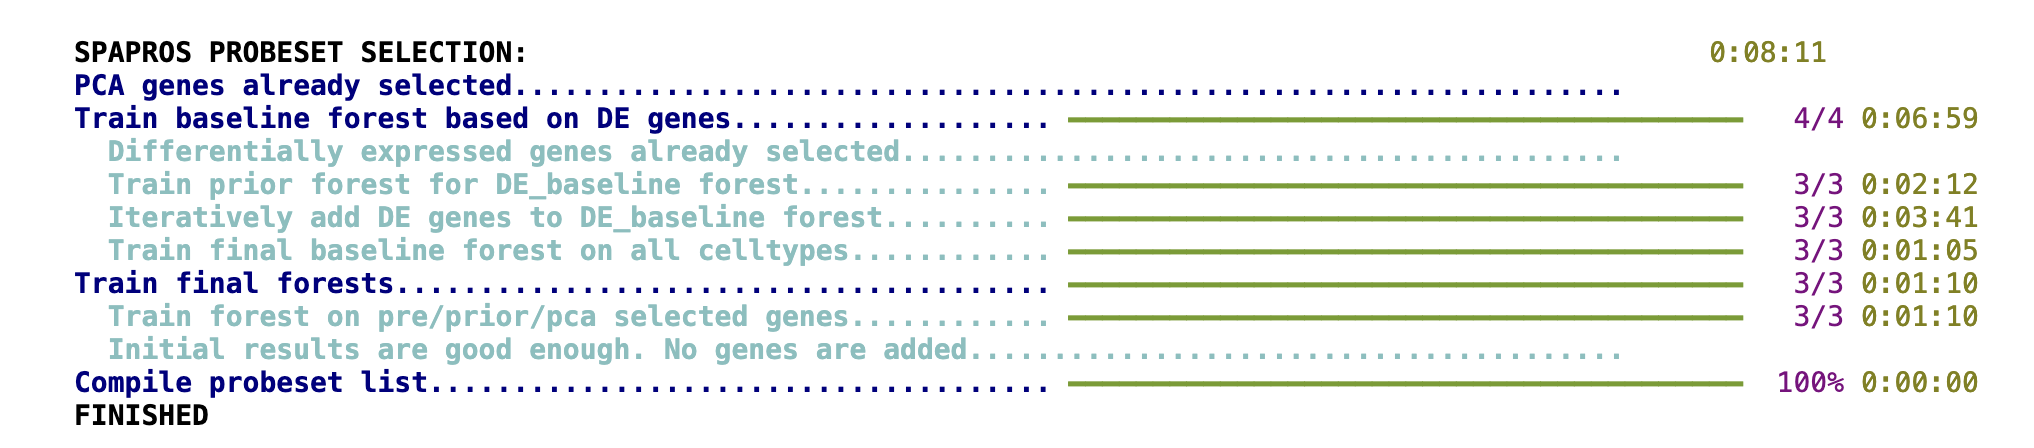

In [7]:
# copy precomputed results to writable working dir
! cp -r $datadir/spapros_selection_basic . 

The same method loads results if available: 

In [8]:
selector.save_dir

'spapros_selection_basic'

In [9]:
selector.select_probeset()

SPAPROS PROBESET SELECTION:                                                                      0:00:00
PCA genes already selected..................................................................  
Train baseline forest based on DE genes................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4/4 0:00:00
  Differentially expressed genes already selected...........................................  
  Prior forest for DE_baseline forest already trained.......................................  
  DE genes already added....................................................................  
  DE_baseline forest already trained........................................................  
Train final forests....................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3/3 0:00:00
  Forest on pre/prior/pca selected genes already trained....................................  
  Initial results are good enough. No genes are added.......................................  
Compile probeset list..................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
FINISHED

The selected probeset can be examined like this:   
(See the [ProbesetSelector.probeset attribute](../se/spapros.se.ProbesetSelector.rst) for a detailed description of the output table)

In [10]:
selector.probeset

,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
PF4,1,True,1.0,1.0,1.0,1.000000,0.810406,False,False,True,Megakaryocytes,,Megakaryocytes,Megakaryocytes,False,True,False
CD79A,2,True,1.0,1.0,1.0,0.916721,1.226540,False,False,True,B cells,,B cells,B cells,False,True,False
S100A8,3,True,1.0,1.0,1.0,0.736796,2.254598,False,False,True,CD14+ Monocytes,,CD14+ Monocytes,CD14+ Monocytes,False,True,False
HLA-DQA1,4,True,1.0,1.0,1.0,0.693026,0.755409,False,False,True,,Dendritic cells,Dendritic cells,Dendritic cells,False,True,False
FCGR3A,5,True,1.0,1.0,1.0,0.604625,1.321373,False,False,True,,FCGR3A+ Monocytes,FCGR3A+ Monocytes,FCGR3A+ Monocytes,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARHGAP19,996,False,NaN,NaN,NaN,NaN,0.016906,False,False,False,,,,,False,False,False
SLC22A4,997,False,NaN,NaN,NaN,NaN,0.016718,False,False,False,,,,,False,False,False
DRAXIN,998,False,NaN,NaN,NaN,NaN,0.016547,False,False,False,,,,,False,False,False
C1QC,999,False,NaN,NaN,NaN,NaN,0.014339,False,False,False,,,,,False,False,False


The list of selected genes can be retrieved with

In [11]:
selector.probeset.index[selector.probeset.selection]

Index(['PF4', 'CD79A', 'S100A8', 'HLA-DQA1', 'FCGR3A', 'GZMB', 'CCL5', 'IL32',
       'HLA-DPB1', 'NKG7', 'LST1', 'LTB', 'FCN1', 'GZMK', 'TYROBP', 'HLA-DRB1',
       'GNLY', 'CST3', 'HLA-DPA1', 'AIF1'],
      dtype='object')

## Vizualize and investigate the results

Let's first plot the mean expression in each cell type cluster with some additional information for the selected genes.

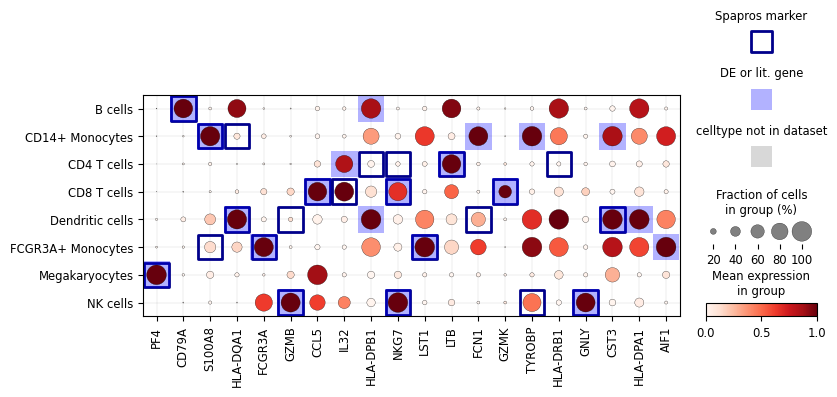

In [12]:
sp.pl.masked_dotplot(adata, selector)

For each cell type the Spapros markers are those that build a combinatorial rule to classify the cell type. Often you find cell type specific markers, and negative markers. When selecting genes for high numbers of cell types including similar clusters the rules tend to show more sophisticated combinatorics.

The Spapros selection procedure consists of multiple steps, we can also investigate how many genes originate from the different steps:

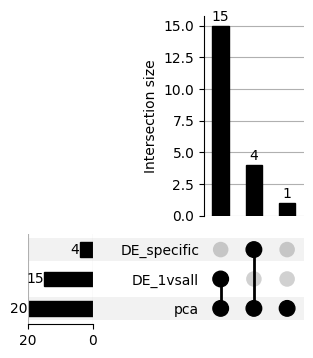

In [13]:
selector.plot_gene_overlap()

- All finally selected 20 genes occured in the PCA-based pre-selection which selects genes that capture a high amount of variation
- they strongly overlap with the (16) differentially expressed genes since marker genes are one source of high variation in transcriptomics data. The overlap is especially high for datasets with only a few cell type clusters that are also well separated as in the given example.
- The first DE tests to train optimal classification trees are tests between each cell type and all other cell types as background (DE_1vsall). To further optimise the trees we run DE tests between cell type clusters that are more difficult to distinguish (DE_specific). We find 4 genes that originate from the specific tests that didn't occur in the 1 vs all tests.

## What's next?

You can now evaluate the selected probeset. See our [basic evaluation tutorial](./spapros_tutorial_basic_evaluation.ipynb).

If you want to customize and improve the probeset selection, have a look at the [advanced selection tutorial](./spapros_tutorial_advanced_selection.ipynb).

Check out the [end-to-end selection tutorial](./spapros_tutorial_end_to_end_selection.ipynb) for the full pipline that includes probe design and gene panel selection.